In [ ]:
import pandas as pd
import requests


import matplotlib.pyplot as plt
import plotly.express as px

import pytz
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import os
import glob
from dotenv import load_dotenv

In [ ]:


# Load environment variables
load_dotenv()

API_KEY = os.getenv("OPENAQ_API_KEY")

In [ ]:
# === STEP 1: EXTRACT ===
url = "https://api.openaq.org/v3/measurements"
params = {
    "location": "Nairobi",      # or try "Nairobi US Embassy" if needed
    "parameter": ["pm25"],
    "limit": 1000,
    "sort": "desc"
}

response = requests.get(url, params=params)
data = response.json()

# Check if data exists
if "results" in data:
    df = pd.DataFrame(data["results"])
else:
    print("⚠️ No results key found — full API response below:")
    print(data)
    df = pd.DataFrame()  # empty dataframe fallback

⚠️ No results key found — full API response below:
{'message': 'Unauthorized. A valid API key must be provided in the X-API-Key header.'}


In [ ]:
import os
import glob
import pandas as pd

def combine_and_filter_by_location(folder_path, location="Nairobi CMR"):
    """
    Combines all CSV files in a folder and filters rows by location name,
    keeping all columns in the original files.

    Args:
        folder_path (str): Path to the folder containing CSV files.
        location (str): Location name to filter (e.g., 'Nairobi CMR').

    Returns:
        pd.DataFrame: Combined and filtered DataFrame.
    """
    all_dfs = []
    csv_files = glob.glob(os.path.join(folder_path, "*.csv"))

    if not csv_files:
        print("No CSV files found.")
        return pd.DataFrame()

    for file in csv_files:
        try:
            df = pd.read_csv(file)
            # Filter by location
            df = df[df['location_name'] == location]
            all_dfs.append(df)
        except Exception as e:
            print(f"" Error reading {file}: {e}")
            continue
        

    if not all_dfs:
        print("No data matched the location filter.")
        return pd.DataFrame()

    combined_df = pd.concat(all_dfs, ignore_index=True)
    return combined_df


In [109]:
AQI_data_Nairobi_CMR = combine_and_filter_by_location("C:\\Users\\Admin\\OneDrive - United States International University (USIU)\\Documents\\KULU_Doc\\Github\\AQI\\Data")
AQI_data_Nairobi_CMR.head(10)
AQI_data_Nairobi_CMR.to_csv("AQI_data_Nairobi_CMR.csv")

In [ ]:
def wrangle_aqi_file(file_path, parameter="pm25"):
    try:
        df = pd.read_csv(file_path)
    except Exception as e:
        print(f"Error reading file: {e}")
        return pd.DataFrame()

    # Filter by parameter
    df = df[df['parameter'] == parameter]

    # If filtering removed everything, return empty
    if df.empty:
        print(f"No data for parameter '{parameter}' in {file_path}")
        return pd.DataFrame()

    if 'datetimeLocal' not in df.columns or 'value' not in df.columns:
        print("Missing 'datetimeLocal' or 'value' columns.")
        return pd.DataFrame()

    df['datetimeLocal'] = pd.to_datetime(df['datetimeLocal'], errors='coerce')
    df = df.dropna(subset=['datetimeLocal'])
    df['timestamp'] = df['datetimeLocal'].dt.floor('h')

    df = df.groupby('timestamp')['value'].mean().reset_index()
    df = df.rename(columns={'value': 'pm25'})

    # Check again before reindexing
    if df.empty:
        print("No data left after grouping.")
        return pd.DataFrame()

    full_range = pd.date_range(start=df['timestamp'].min(), end=df['timestamp'].max(), freq='h')
    df = df.set_index('timestamp').reindex(full_range)
    df.index.name = 'timestamp'

    return df


In [ ]:

# Load and clean
file_path = r"C:\Users\Admin\OneDrive - United States International University (USIU)\Documents\KULU_Doc\Github\AQI\AQI_Project\AQI_data_Nairobi_CMR.csv"
df = wrangle_aqi_file(file_path)

df.head()


,pm25
timestamp,
2025-02-06 21:00:00+03:00,0.8
2025-02-06 22:00:00+03:00,1.0
2025-02-06 23:00:00+03:00,1.1
2025-02-07 00:00:00+03:00,1.2
2025-02-07 01:00:00+03:00,1.0


In [112]:
print(df.tail())

                           pm25
timestamp                      
2025-06-13 23:00:00+03:00  47.9
2025-06-14 00:00:00+03:00  22.0
2025-06-14 01:00:00+03:00  22.5
2025-06-14 02:00:00+03:00  29.3
2025-06-14 03:00:00+03:00  29.1


In [113]:
print(len(df))
print(df.isna().sum())


3055
pm25    73
dtype: int64


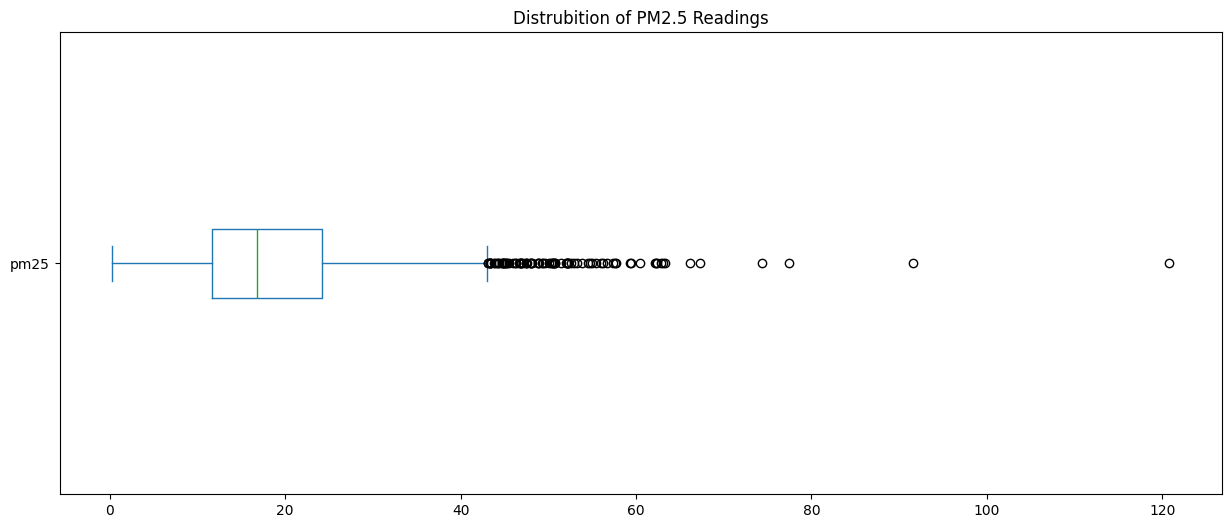

In [114]:
fig, ax = plt.subplots(figsize=(15, 6))
df["pm25"].plot(kind="box",vert=False,title="Distrubition of PM2.5 Readings",ax=ax);

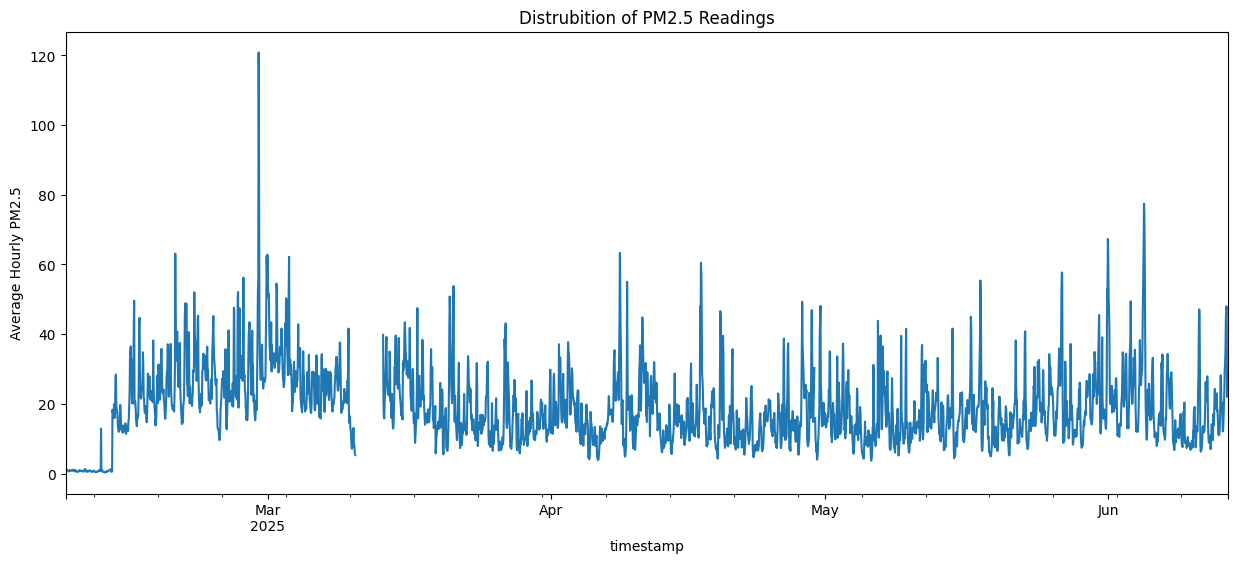

In [115]:
fig, ax = plt.subplots(figsize=(15, 6))
df["pm25"].plot(kind="line", ylabel="Average Hourly PM2.5",title="Distrubition of PM2.5 Readings",ax=ax);

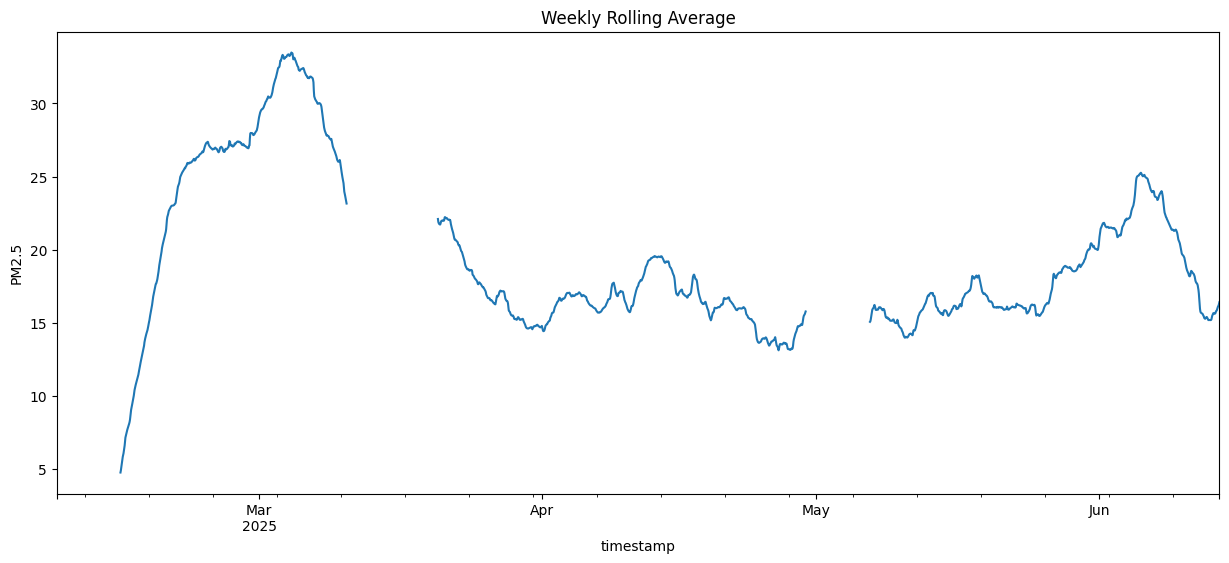

In [116]:
fig, ax = plt.subplots(figsize=(15, 6))
df["pm25"].rolling(168).mean().plot(ax=ax,ylabel="PM2.5", title="Weekly Rolling Average");

In [117]:
df["pm25"] = df["pm25"].ffill()

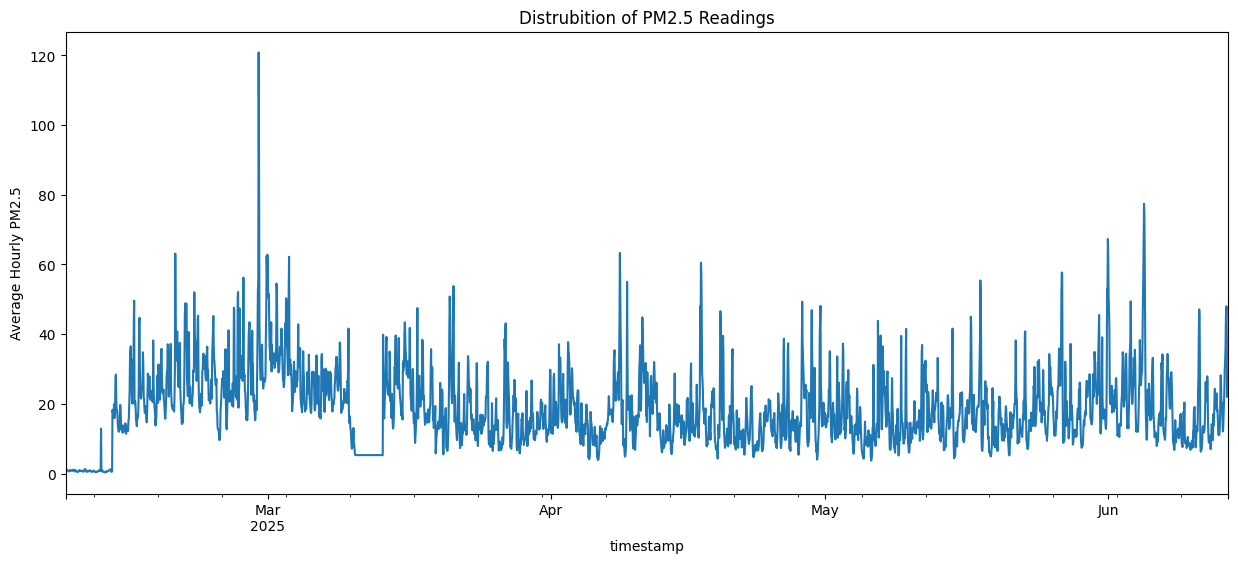

In [118]:
fig, ax = plt.subplots(figsize=(15, 6))
df["pm25"].plot(kind="line", ylabel="Average Hourly PM2.5",title="Distrubition of PM2.5 Readings",ax=ax);

### Rolling Window and  Line plot with time series

In [119]:
# number of hours in A wee
df["pm25"].rolling(168).mean().isnull().sum()

167

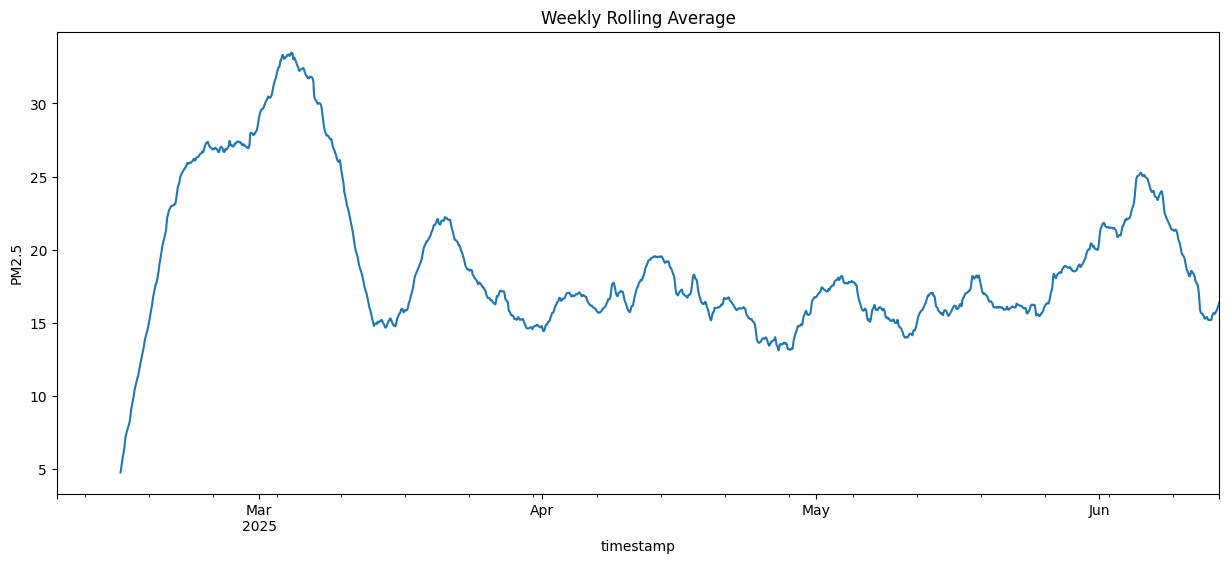

In [120]:
fig, ax = plt.subplots(figsize=(15, 6))
df["pm25"].rolling(168).mean().plot(ax=ax,ylabel="PM2.5", title="Weekly Rolling Average");

### Shift

In [121]:
# Create lagged feature
df['pm25.L1'] = df['pm25'].shift(1)

# Drop rows with NaNs (first row will have NaN due to shift)
df = df.dropna(subset=['pm25', 'pm25.L1'])

In [122]:
print("null",df.isnull().sum())

null pm25       0
pm25.L1    0
dtype: int64


### Correlation matrix

In [123]:
df.corr()

,pm25,pm25.L1
pm25,1.000000,0.861149
pm25.L1,0.861149,1.000000


### Scatter Plot

Text(0.5, 1.0, 'PM2.5 Autocorrelation')

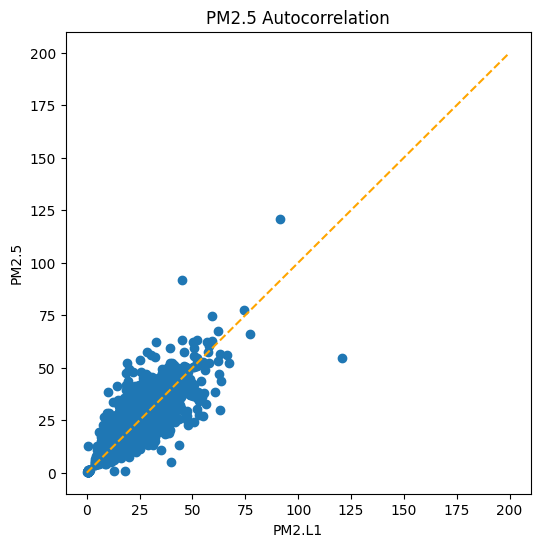

In [124]:
ig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(x=df["pm25"],y=df["pm25.L1"])
ax.plot([0,200],[0,200],linestyle="--",color="orange")
plt.xlabel("PM2.L1")
plt.ylabel("PM2.5")
plt.title("PM2.5 Autocorrelation")

### Split

In [125]:
target = "pm25"
y = df[target]
X = df.drop(columns=target)
# Step 2: Train-test split (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False  # no shuffling for time series
)


In [126]:
print("X_train",len(X_train))
print("X_test",len(X_test))
print("y_train",len( y_train))
print("Y_test",len(y_test))

X_train 2443
X_test 611
y_train 2443
Y_test 611


### Base Line Model

In [127]:

# Step 3: Baseline prediction — predict the mean of y_train
y_pred_baseline = [y_train.mean()] * len(y_train)

# Step 4: Evaluate using MAE
mae_baseline = mean_absolute_error(y_train, y_pred_baseline)

# Step 5: Print results
print("📊 Mean PM Reading (Train):", round(y_train.mean(), 2))
print("🔧 Baseline MAE:", round(mae_baseline, 2))

📊 Mean PM Reading (Train): 18.27
🔧 Baseline MAE: 8.32


### Linear Regression with Time Series Data

In [128]:
model = LinearRegression()
model.fit(X_train,y_train)

LinearRegression()

In [129]:
y_train_predict = model.predict(X_train)
y_test_predict = model.predict(X_test)

In [130]:
training_mae = mean_absolute_error(y_train,y_train_predict)
test_mae =  mean_absolute_error(y_test,y_test_predict)
print("Training MAE:", round(training_mae, 2))
print("Test MAE:", round(test_mae, 2))

Training MAE: 3.57
Test MAE: 3.55


### Communicate The Results

In [131]:
intercept=model.intercept_.round(2)
coefficient=model.coef_.round(2)
print(f"P2 = {intercept} + ({coefficient} * P2.L1)")

P2 = 2.58 + ([0.86] * P2.L1)


In [132]:
df_pred_test = pd.DataFrame(
    {
        "y_test":y_test,
        "y_pred":model.predict(X_test)
    }

)
df_pred_test.tail()

,y_test,y_pred
timestamp,,
2025-06-13 23:00:00+03:00,47.9,43.817615
2025-06-14 00:00:00+03:00,22.0,43.731699
2025-06-14 01:00:00+03:00,22.5,21.479682
2025-06-14 02:00:00+03:00,29.3,21.909258
2025-06-14 03:00:00+03:00,29.1,27.751486


In [133]:
fig = px.line(df_pred_test,labels={"Value":"PM25"})
fig.show()

### Time series line plot for the values in test_predictions using plotly express.

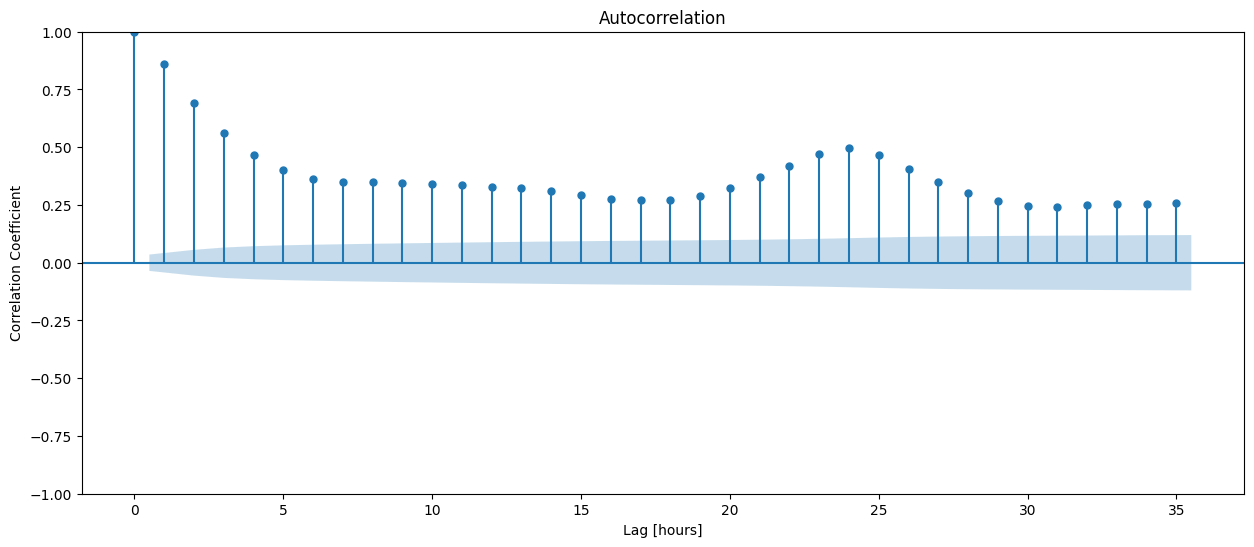

In [134]:
fig, ax = plt.subplots(figsize=(15, 6))
plot_acf(y,ax=ax)
plt.xlabel("Lag [hours]")
plt.ylabel("Correlation Coefficient");

# Autoregressive Model 

In [135]:
from statsmodels.tsa.ar_model import AutoReg

## Explore

### ACF plot

In [136]:
y=df["pm25"]
y.isnull().sum()

0

In [137]:
# ACF PLOT
# What happend before "1H"??
y.corr(y.shift(1))  # We know that before

0.8610290657156018

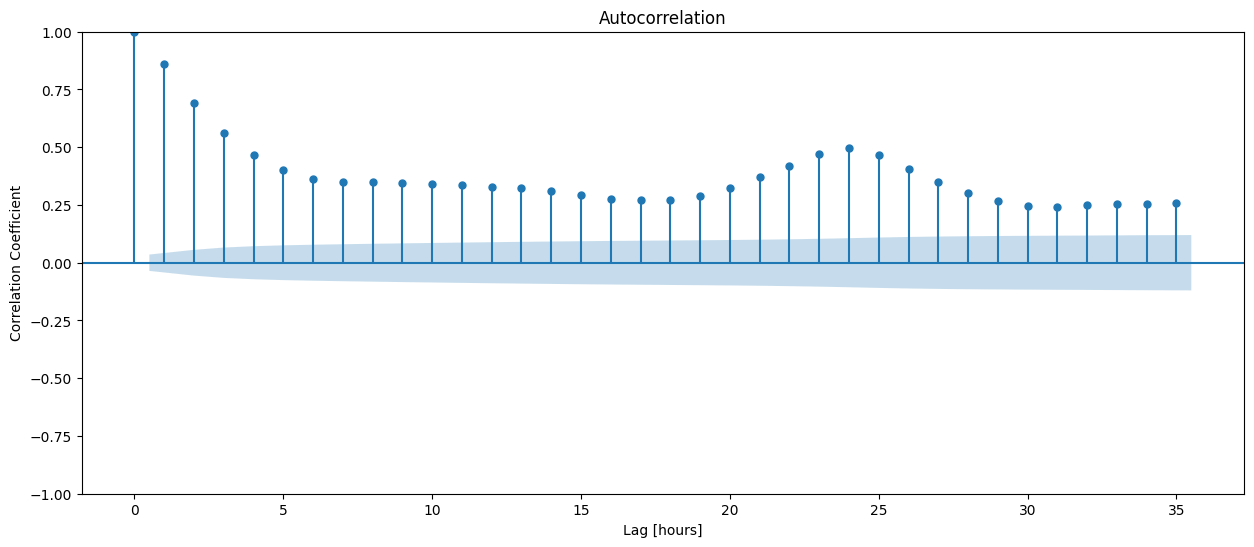

In [138]:
fig, ax = plt.subplots(figsize=(15, 6))
plot_acf(y,ax=ax)
plt.xlabel("Lag [hours]")
plt.ylabel("Correlation Coefficient");

### PACF PLOT

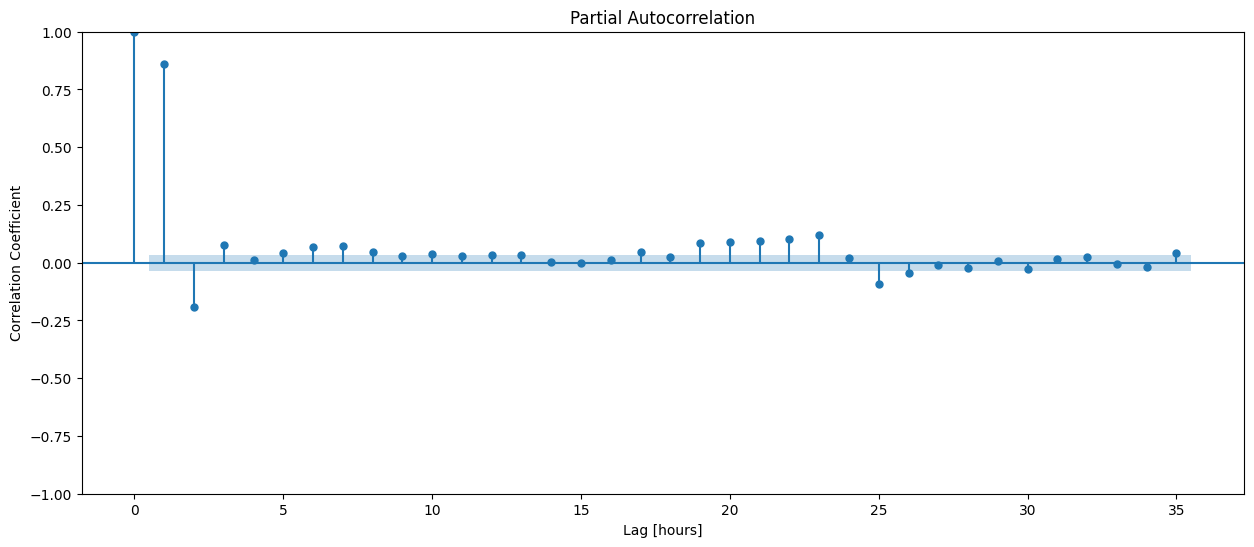

In [139]:
fig, ax = plt.subplots(figsize=(15, 6))

plot_pacf(y,ax=ax)
plt.xlabel("Lag [hours]")
plt.ylabel("Correlation Coefficient");

## Build Model - Autoregressive Model 

In [157]:
model = AutoReg(y_train,lags=26).fit(); 

In [158]:
y_pred = model.predict()
y_pred.isnull().sum()

26

In [160]:
y_pred = model.predict().dropna()
training_mae =mean_absolute_error(y_train.iloc[26:],y_pred)
print("Training MAE:", training_mae)

Training MAE: 3.2863025322911326


In [162]:
df_pred_test = pd.DataFrame(
    {
        "y_train":y_train,
        "y_pred":y_pred
    }

)
df_pred_test.tail()

,y_train,y_pred
timestamp,,
2025-05-19 12:00:00+03:00,8.1,11.167970
2025-05-19 13:00:00+03:00,9.7,11.504440
2025-05-19 14:00:00+03:00,8.4,12.227655
2025-05-19 15:00:00+03:00,7.5,11.066560
2025-05-19 16:00:00+03:00,13.5,9.971443


### Residuals

In [167]:

y_train_resid=model.resid
y_train_resid.tail()

timestamp
2025-05-19 12:00:00+03:00   -3.067970
2025-05-19 13:00:00+03:00   -1.804440
2025-05-19 14:00:00+03:00   -3.827655
2025-05-19 15:00:00+03:00   -3.566560
2025-05-19 16:00:00+03:00    3.528557
Freq: h, dtype: float64

In [168]:
# OR
y_train_resid = (y_train-y_pred).to_frame()
y_train_resid.tail()

,0
timestamp,
2025-05-19 12:00:00+03:00,-3.067970
2025-05-19 13:00:00+03:00,-1.804440
2025-05-19 14:00:00+03:00,-3.827655
2025-05-19 15:00:00+03:00,-3.566560
2025-05-19 16:00:00+03:00,3.528557


### Line plot for Residuals 

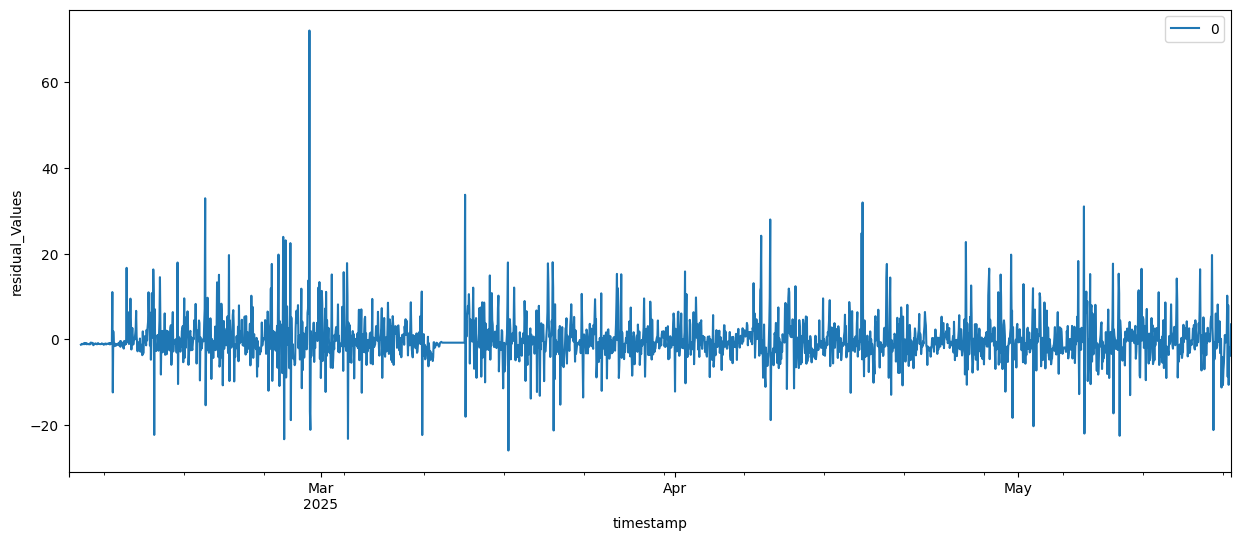

In [169]:
fig, ax = plt.subplots(figsize=(15, 6))
y_train_resid.plot(ylabel="residual_Values",ax=ax);

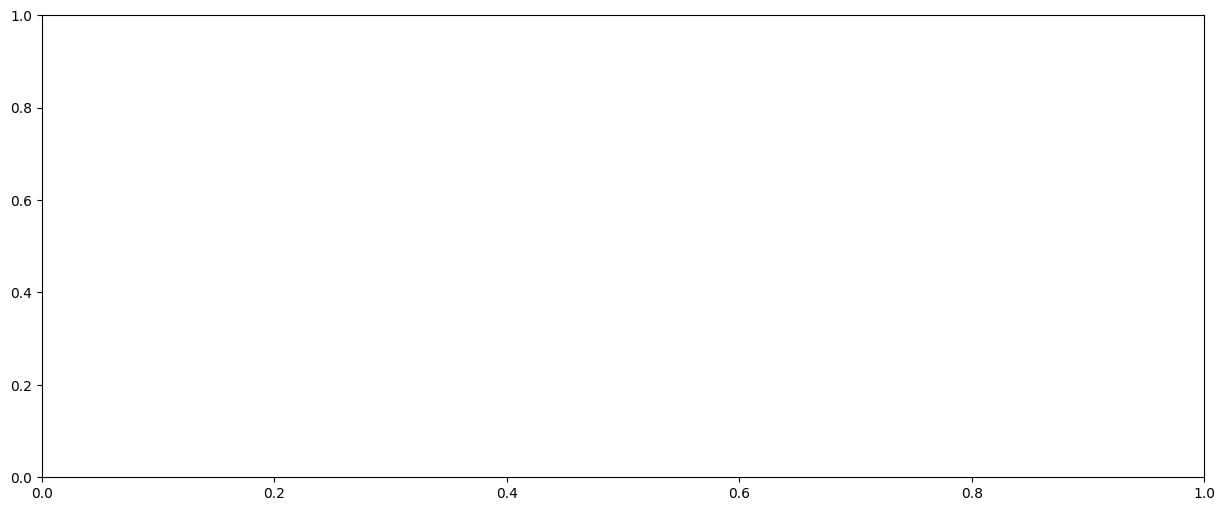

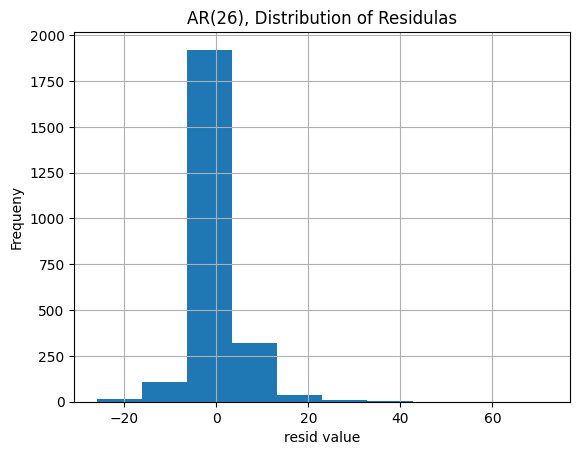

In [146]:
fig, ax = plt.subplots(figsize=(15, 6))
y_train_resid.hist()
plt.xlabel("resid value")
plt.ylabel("Frequeny")
plt.title("AR(26), Distribution of Residulas");

## Evaluate

In [170]:
# Evaluation
y_pred_test = model.predict(y_test.index.min(),y_test.index.max())
test_mae = mean_absolute_error(y_test,y_pred_test)
print("Test MAE:", test_mae)

Test MAE: 7.430166570685543


In [148]:
df_pred_test = pd.DataFrame(
    {"y_test": y_test, "y_pred": y_pred_test}, index=y_test.index
)

In [149]:
fig = px.line(df_pred_test, labels={"value": "P2"})
fig.show()

### WFP

In [150]:
%%capture

y_pred_wfv = pd.Series()
history = y_train.copy()
for i in range(len(y_test)):
    
    model=AutoReg(history,lags=26).fit()
    next_pred=model.forecast()
    y_pred_wfv = pd.concat([y_pred_wfv, next_pred])
    history= pd.concat([history, y_test[next_pred.index]])

In [151]:
test_mae = mean_absolute_error(y_test,y_pred_wfv)
print("Test MAE (walk forward validation):", round(test_mae, 2))

Test MAE (walk forward validation): 3.46


### Communication Results

In [152]:
equation=pd.DataFrame(model.params,columns=["Coeeficients"])
equation.head()


,Coeeficients
const,1.226196
pm25.L1,0.971941
pm25.L2,-0.246544
pm25.L3,0.070609
pm25.L4,-0.020551


In [153]:
fig= px.line(df_pred_test, labels={"value": "P2"})
fig.show()

## ARMA

In [154]:
from statsmodels.tsa.arima.model import ARIMA
import time

In [155]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(df["pm25"])
print("ADF Statistic:", result[0])
print("p-value:",result[1])

ADF Statistic: -4.896656347118897
p-value: 3.540077625168462e-05


The more negative the ADF statistic, the stronger the evidence against non-stationarity (i.e., stronger evidence that the series is stationary).
The p-value is far below 0.05, which means: Reject the null hypothesis (H₀) that the series has a unit root (i.e., is non-stationary).
pm25 series is stationary.

In [156]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Assuming df has a datetime index and 'pm25' column
df = df.set_index('timestamp')
df = df.asfreq('H')  # Ensure hourly frequency
df['pm25'] = df['pm25'].interpolate()  # Handle any missing values

# Fit SARIMA model
model = SARIMAX(df['pm25'], 
                order=(1, 1, 1), 
                seasonal_order=(1, 1, 1, 24*7),  # weekly seasonality
                enforce_stationarity=False, 
                enforce_invertibility=False)

result = model.fit(disp=False)

# Forecast next 168 hours (1 week)
forecast = result.get_forecast(steps=168)
forecast_index = pd.date_range(start=df.index[-1]+pd.Timedelta(hours=1), periods=168, freq='H')
forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int()

# Plot
plt.figure(figsize=(15,6))
plt.plot(df['pm25'], label='Observed', alpha=0.7)
plt.plot(forecast_index, forecast_mean, label='Forecast', color='red')
plt.fill_between(forecast_index, 
                 forecast_ci.iloc[:, 0], 
                 forecast_ci.iloc[:, 1], 
                 color='pink', alpha=0.3, label='Confidence Interval')
plt.title("SARIMA Forecast of PM2.5 Levels (Next Week)")
plt.xlabel("Time")
plt.ylabel("PM2.5")
plt.legend()
plt.tight_layout()
plt.show()


KeyError: "None of ['timestamp'] are in the columns"

In [ ]:
# Resample by month and count the number of entries per month
monthly_counts = y.resample('D').size()[:5]
print(monthly_counts)

timestamp
2025-02-06 00:00:00+03:00     2
2025-02-07 00:00:00+03:00    24
2025-02-08 00:00:00+03:00    24
2025-02-09 00:00:00+03:00    24
2025-02-10 00:00:00+03:00    24
Freq: D, Name: pm25, dtype: int64


In [ ]:
# Resample by month and count the number of entries per month
monthly_counts = y.resample('M').size()
print(monthly_counts)

timestamp
2025-02-28 00:00:00+03:00    530
2025-03-31 00:00:00+03:00    744
2025-04-30 00:00:00+03:00    720
2025-05-31 00:00:00+03:00    744
2025-06-30 00:00:00+03:00    316
Freq: ME, Name: pm25, dtype: int64


C:\Users\Admin\AppData\Local\Temp\ipykernel_21652\3872033758.py:2: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.



In [ ]:
# to count per a Year
print(y.resample('Y').size())

timestamp
2025-12-31 00:00:00+03:00    3054
Freq: YE-DEC, Name: pm25, dtype: int64


C:\Users\Admin\AppData\Local\Temp\ipykernel_21652\2488238660.py:2: FutureWarning:

'Y' is deprecated and will be removed in a future version, please use 'YE' instead.



### Split

In [ ]:
target = "pm25"
y = df[target]
X = df.drop(columns=target)
# Step 2: Train-test split (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False  # no shuffling for time series
)
print("X_train",len(X_train))
print("X_test",len(X_test))
print("y_train",len( y_train))
print("Y_test",len(y_test))

X_train 2443
X_test 611
y_train 2443
Y_test 611


### Hyperparameter

In [ ]:
p_params = range(0,25,8)
q_params = range(0,3,1)

In [ ]:
for p in p_params:
    for q in q_params:
        order=(p,0,q)
        start_time=time.time()
        model=ARIMA(y_train,order=order).fit()
        elapsed_time=round(time.time()-start_time,2)
        print(f"Trained Model ARIMA{order} in {elapsed_time}.")
        #Generating y_pred
        y_pred=model.predict()
        mae=mean_absolute_error(y_train,y_pred)
        print(mae)

Trained Model ARIMA(0, 0, 0) in 1.1.
8.322680143668613


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.



Trained Model ARIMA(0, 0, 1) in 0.75.
5.432708122768804
Trained Model ARIMA(0, 0, 2) in 1.24.
4.471850013817788
Trained Model ARIMA(8, 0, 0) in 4.26.
3.4371679241772912


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Trained Model ARIMA(8, 0, 1) in 14.33.
3.3568274877737383


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Trained Model ARIMA(8, 0, 2) in 13.96.
3.375669217020406
Trained Model ARIMA(16, 0, 0) in 22.83.
3.416287302783123


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Trained Model ARIMA(16, 0, 1) in 42.93.
3.4189589635576856


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Trained Model ARIMA(16, 0, 2) in 65.26.
3.4184115641315262
Trained Model ARIMA(24, 0, 0) in 29.81.
3.27249002550863
Trained Model ARIMA(24, 0, 1) in 72.42.
3.262708261252752


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Trained Model ARIMA(24, 0, 2) in 73.23.
3.267675494188098


Trained ARIMA(0, 0, 0) in 0.89s
MAE: 8.322680143668613


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.



Trained ARIMA(0, 0, 1) in 0.62s
MAE: 5.432708122768804
Trained ARIMA(0, 0, 2) in 0.89s
MAE: 4.471850013817788
Trained ARIMA(8, 0, 0) in 2.11s
MAE: 3.4371679241772912


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Trained ARIMA(8, 0, 1) in 11.6s
MAE: 3.3568274877737383


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Trained ARIMA(8, 0, 2) in 13.07s
MAE: 3.375669217020406
Trained ARIMA(16, 0, 0) in 16.82s
MAE: 3.416287302783123


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Trained ARIMA(16, 0, 1) in 32.47s
MAE: 3.4189589635576856


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Trained ARIMA(16, 0, 2) in 39.26s
MAE: 3.4184115641315262
Trained ARIMA(24, 0, 0) in 27.03s
MAE: 3.27249002550863
Trained ARIMA(24, 0, 1) in 74.71s
MAE: 3.262708261252752


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Trained ARIMA(24, 0, 2) in 68.32s
MAE: 3.267675494188098


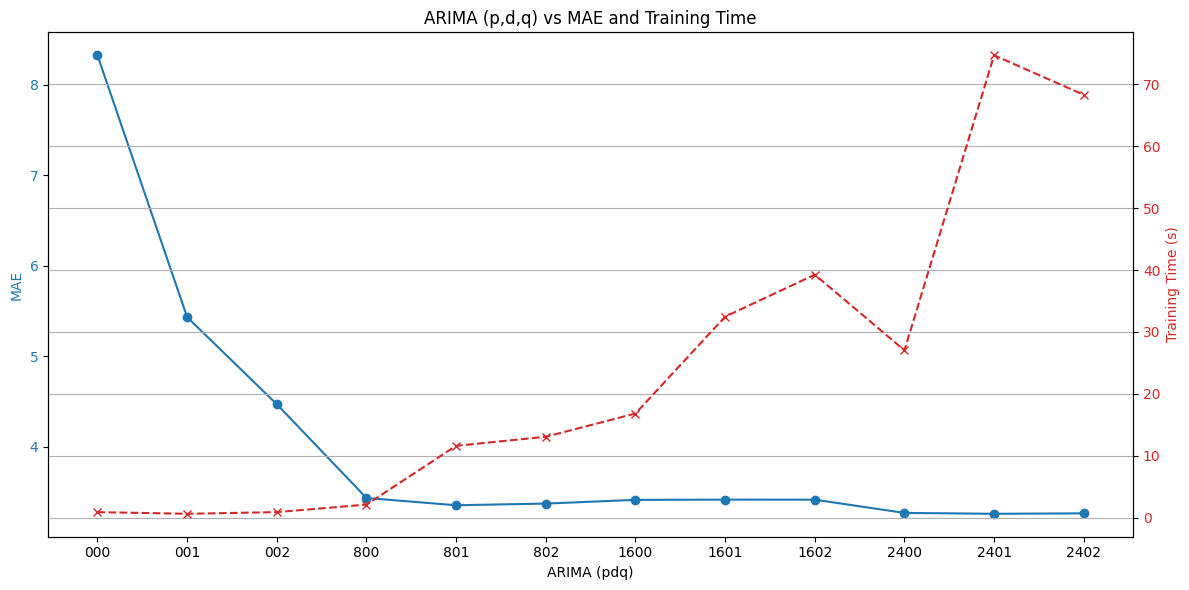

In [ ]:

results = []

for p in p_params:
    for q in q_params:
        order = (p, 0, q)
        start_time = time.time()
        model = ARIMA(y_train, order=order).fit()
        elapsed_time = round(time.time() - start_time, 2)
        print(f"Trained ARIMA{order} in {elapsed_time}s")

        y_pred = model.predict()
        mae = mean_absolute_error(y_train, y_pred)
        print(f"MAE: {mae}")

        results.append({
            "pdq": f"{p}{d}{q}",
            "mae": mae,
            "time": elapsed_time
        })

# Convert to DataFrame
results_df = pd.DataFrame(results)

# Plotting
fig, ax1 = plt.subplots(figsize=(12, 6))

color_mae = 'tab:blue'
color_time = 'tab:red'

# First Y-axis: MAE
ax1.set_xlabel('ARIMA (pdq)')
ax1.set_ylabel('MAE', color=color_mae)
ax1.plot(results_df['pdq'], results_df['mae'], marker='o', color=color_mae, label='MAE')
ax1.tick_params(axis='y', labelcolor=color_mae)

# Second Y-axis: Time Elapsed
ax2 = ax1.twinx()
ax2.set_ylabel('Training Time (s)', color=color_time)
ax2.plot(results_df['pdq'], results_df['time'], marker='x', linestyle='--', color=color_time, label='Time')
ax2.tick_params(axis='y', labelcolor=color_time)

# Title and Grid
plt.title('ARIMA (p,d,q) vs MAE and Training Time')
fig.tight_layout()
plt.grid(True)
plt.show()
